# S Forecast TensorFlow

## Contents

The notebook demonstrates how to employ sforecast train/test fit (sliding/expanding window out-of-sample train/test) to make forecast fits and predictions with Tensorflow models 

The notebook demonstrates the mechanics of setting up and running the corresponding data and models. 

Sections
   * Initialize Notebook
   * Load Data - M5 Sales data 7 items
   * M5 Walmart Sales Data, 7 Items
   * Univariate and Exogenous Variables
   * Univariate and Categorical Embeddings
   * Multivariage Exogenous, Categorical
   * Train Test Validation
   * Multivariate Exen Groups, Exogenous, Categorical
   *  LSTM + Exogenous + Categorical Embeddngs, Multivariate
   *  

## Initialize Notebook

General Imports

In [1]:
import sforecast as sf
print(f'sforecast version = {sf.__version__}')
import pandas as pd
import numpy as np
import beautifulplots as bp
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from pandas.plotting import autocorrelation_plot
datapath = "../data"

2024-07-24 06:14:44.318784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


sforecast version = 0.6.3


TensorFlow Imports

In [2]:
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

## M5 Sales data 7 items

M5 Sales 7 Items

In [3]:

df_m5sales7 = pd.read_csv("../data/m5_sales_7_items_events_cci_wide.csv", parse_dates = ["date"])
df_m5sales7 = df_m5sales7.set_index("date")
print("df_m5sales7")
display(df_m5sales7.tail())

# variable types
covars = [c for c in df_m5sales7.columns if "unit_sales_CA1_" in c]
catvars = [ "weekday", "event_name_1","event_name_2"]
exogvars = [ "year", "month" , "week",  "snap_CA",  "CCI_USA"]
Ncatvars = len(catvars)
Ncovars = len(covars)
Nexogvars = len(exogvars)

# dfXY ... covars + exogvars + catvars
cols = covars+catvars+exogvars
dfXY = df_m5sales7[cols].copy()

# label Encoding
le_catvars = [ "le_"+c for c in ["event_name_1","event_name_2"] ] # label encoded category columns ... weekday already encoded
print(le_catvars)
le = LabelEncoder()
dfXY[le_catvars] =dfXY[["event_name_1","event_name_2"] ].apply(le.fit_transform)
weekday_num = {"Sunday":0, "Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4, "Friday":5, "Saturday":6}
dfXY["le_weekday"] = dfXY["weekday"].apply( lambda x: weekday_num[x]) # create our own labels or label_encoder creates arbitrary number assignments
le_catvars = ["le_weekday"] + le_catvars # weekday is alread encoded ... add to le_catvars 
print(f'le_catvars = {le_catvars}')
print(f'N event_name_1 labels = {dfXY.groupby("event_name_1")["event_name_1"].count().index.size}')

# embedding dimensions
eindim = [dfXY[le_catvars].groupby(c)[c].count().index.size + 1 for c in le_catvars] # add 1 to the dim or err in TF
eoutdim = [np.rint(np.log2(x)).astype(int) for x in eindim]
print(f'eindim = {eindim}')
print(f'eoutdim = {eoutdim}')

# display dfXY
print(f'dfXY.shape = {dfXY.shape}')
print(f'\ndfXY.head = ')
display(dfXY.head())

df_m5sales7


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,sell_price_CA1_HOUSEHOLD_416,sell_price_CA1_FOODS_044,sell_price_CA1_FOODS_030,...,sell_price_CA1_FOODS_393,year,month,week,weekday,yearmonth,event_name_1,event_name_2,snap_CA,CCI_USA
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,3.88,2.5,1.48,...,3.56,2016,5,20,Wednesday,201605,NaN,NaN,0,100.7612
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,3.88,2.5,1.48,...,3.56,2016,5,20,Thursday,201605,NaN,NaN,0,100.7612
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,3.88,2.5,1.48,...,3.56,2016,5,20,Friday,201605,NaN,NaN,0,100.7612
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,3.88,2.5,1.48,...,3.56,2016,5,20,Saturday,201605,NaN,NaN,0,100.7612
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,3.88,2.5,1.48,...,3.56,2016,5,20,Sunday,201605,NaN,NaN,0,100.7612


['le_event_name_1', 'le_event_name_2']
le_catvars = ['le_weekday', 'le_event_name_1', 'le_event_name_2']
N event_name_1 labels = 30
eindim = [8, 32, 5]
eoutdim = [3, 5, 2]
dfXY.shape = (1206, 18)

dfXY.head = 


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,weekday,event_name_1,event_name_2,year,month,week,snap_CA,CCI_USA,le_event_name_1,le_event_name_2,le_weekday
date,,,,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,Saturday,NaN,NaN,2013,2,5,1,98.72734,30,3,6
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,Sunday,SuperBowl,NaN,2013,2,5,1,98.72734,26,3,0
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,Monday,NaN,NaN,2013,2,6,1,98.72734,30,3,1
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,Tuesday,NaN,NaN,2013,2,6,1,98.72734,30,3,2
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,Wednesday,NaN,NaN,2013,2,6,1,98.72734,30,3,3


## Univariate with Exogenous

data with exogenous variables

**Exogenous Variables**

These variables are not dependent on the target (independent variable) and are ususally some form of external varialbe. For example, they could represent the weather, such as temperature or rain, or economic data, such as consumer confience index.

The exogenous variables are included in the input dataframe to the fit operation. An exogenous variables dataframe, one row per predict period is input to the predict operation.

Below is trivial example of exogenous variables, the month number is included as an exogenous variable input. df_airp has two variables the target variable and y = Passengers, and exogenous variable month_no

In [4]:
y = ["unit_sales_CA1_FOODS_030"]
dfXYtf = dfXY[ y + exogvars].copy()
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail(5))

['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 6)


,unit_sales_CA1_FOODS_030,year,month,week,snap_CA,CCI_USA
date,,,,,,
2016-05-18,7.0,2016,5,20,0,100.7612
2016-05-19,11.0,2016,5,20,0,100.7612
2016-05-20,9.0,2016,5,20,0,100.7612
2016-05-21,9.0,2016,5,20,0,100.7612
2016-05-22,8.0,2016,5,20,0,100.7612


NN Model Exogenous Univariate

In [5]:
Nlags = 5
tf_model_dense_exog_uv = sf.get_dense_nn( Nlags,  Nexogs = Nexogvars)

Ndense = 10
Ndense = 20
Nout = 1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 20)                220       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 441
Trainable 

2024-07-24 06:15:15.803712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fit

In [6]:
# display data
print("dfXYtf")
display(dfXYtf.tail())

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# Forecast - fit
Ntest=10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "exogvars":exogvars,
    "minmax" :(0,None)
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 100,
    "batch_size":100
    }

sfuvexogtf = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_exog_uv, tf_parameters=tf_params)

df_pred_uvexog = sfuvexogtf.fit(dfXYtf)

print(f'\nmetrics = {sfuvexogtf.metrics}')
dfXY_pred_uvexogtf = dfXYtf.join(df_pred_uvexog)
display(dfXY_pred_uvexogtf.tail())


dfXYtf


,unit_sales_CA1_FOODS_030,year,month,week,snap_CA,CCI_USA
date,,,,,,
2016-05-18,7.0,2016,5,20,0,100.7612
2016-05-19,11.0,2016,5,20,0,100.7612
2016-05-20,9.0,2016,5,20,0,100.7612
2016-05-21,9.0,2016,5,20,0,100.7612
2016-05-22,8.0,2016,5,20,0,100.7612


1/1 [==============================] - 0s 90ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])


1/1 [==============================] - 0s 21ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])


1/1 [==============================] - 0s 20ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])


1/1 [==============================] - 0s 22ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])


1/1 [==============================] - 0s 20ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])


1/1 [==============================] - 0s 21ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])


1/1 [==============================] - 0s 20ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])


1/1 [==============================] - 0s 21ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])


1/1 [==============================] - 0s 19ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])


1/1 [==============================] - 0s 20ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])



metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 1.8606069401225735, 'MAE': 1.3269422054290771}}


,unit_sales_CA1_FOODS_030,year,month,week,snap_CA,CCI_USA,unit_sales_CA1_FOODS_030_train,unit_sales_CA1_FOODS_030_test,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_FOODS_030_pred_error,unit_sales_CA1_FOODS_030_pred_lower,unit_sales_CA1_FOODS_030_pred_upper
date,,,,,,,,,,,,
2016-05-18,7.0,2016,5,20,0,100.7612,NaN,7.0,7.238378,0.238378,3.688588,8.079037
2016-05-19,11.0,2016,5,20,0,100.7612,NaN,11.0,6.851819,-4.148181,3.302030,7.692478
2016-05-20,9.0,2016,5,20,0,100.7612,NaN,9.0,8.800959,-0.199041,5.251169,9.641618
2016-05-21,9.0,2016,5,20,0,100.7612,NaN,9.0,8.310613,-0.689387,4.760824,9.151272
2016-05-22,8.0,2016,5,20,0,100.7612,NaN,8.0,8.760377,0.760377,5.210588,9.601036


Plot

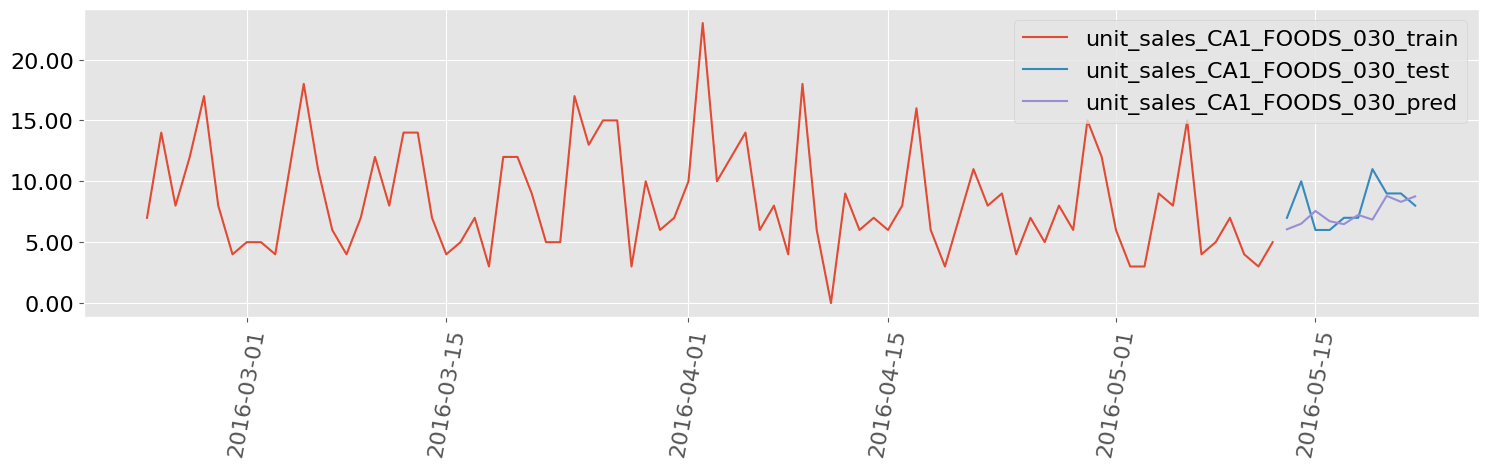

In [7]:
y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

df = dfXY_pred_uvexogtf.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

bp.lineplot(df.tail(90), x="date", y=[ytrain, ytest, ypred], figsize=(18,4),  x_tick_rotation=80)


Predict

In [8]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

df_pred=sfuvexogtf.predict(Nperiods=5,dfexogs = dfexogs, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 22ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])
/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:275: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_index

1/1 [==============================] - 0s 23ms/step


/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:275: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.dfmemory[y].iloc[last_i] = yvalue
/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forec

,unit_sales_CA1_FOODS_030_pred
2016-05-23,6.672907
2016-05-24,6.084330
2016-05-25,5.749767
2016-05-26,5.486476
2016-05-27,5.266145


## Univariate + Categorical Variables

data

In [4]:
# y forecast variable
y = ["unit_sales_CA1_FOODS_030"]
dfXYtf = dfXY[y+le_catvars]
display(dfXYtf.tail(10))

,unit_sales_CA1_FOODS_030,le_weekday,le_event_name_1,le_event_name_2
date,,,,
2016-05-13,7.0,5,30,3
2016-05-14,10.0,6,30,3
2016-05-15,6.0,0,30,3
2016-05-16,6.0,1,30,3
2016-05-17,7.0,2,30,3
2016-05-18,7.0,3,30,3
2016-05-19,11.0,4,30,3
2016-05-20,9.0,5,30,3
2016-05-21,9.0,6,30,3


NN Categorical Univariate

In [5]:
le_catvars

['le_weekday', 'le_event_name_1', 'le_event_name_2']

In [7]:
Nlags = 5
tf_model_dense_emb_uv = sf.get_dense_emb_nn(dfXYtf, Nlags, le_catvars)

Ndense = 5
Nemb = 3
Nout = 1
cont_inputs = KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
cat_inputs_list = [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_6')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_7')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_8')>]
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                          

In [10]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables)
Nlags = 5
Ndense = Nlags  # N continous/dense variables, in this case covars is 1 (univarate)
Nembout = sum(eoutdim)

print("Nlags =", Nlags)
print("Ndense =", Nlags)
print("Nembout =", Nembout)

# Dense Network, 2 hidden layers, continuous variables ...lags
cont_inputs = Input((Ndense,))
h1c = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars

cat_inputs_list = [ Input((1,)) for c in range(Ncatvars) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1c]+emb_flat_list)

# dense reduction layers
Nh1_comb = Ndense + Nembout  # 
h1_comb = Dense(Nh1_comb, activation='relu')(combined)
Nh2_comb = np.rint(Nh1_comb/2).astype(int)
h2_comb = Dense(Nh2_comb, activation='relu')(h1_comb)

# output
output = Dense(1)(h2_comb)  # linear activation ... linear combination 

# build model
model_tf_dense_emb = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)
print(model_tf_dense_emb.summary())

Nlags = 5
Ndense = 5
Nembout = 10
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                          

Fit

In [13]:

# Forcast Fit

Ntest = 10
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "catvars":le_catvars 
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sftfuvc = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_emb_uv, tf_parameters=tf_params)

df_pred_ccm5 = sftfuvc.fit(dfXYtf)

print(f'\nmetrics = {sftfuvc.metrics}')
dfXY_pred_ccm5 = dfXY.join(df_pred_ccm5)
display(dfXY_pred_ccm5.tail())


1/1 [==============================] - 0s 25ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 2.0576795180360827, 'MAE': 1.5648582935333253}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,weekday,event_name_1,event_name_2,...,CCI_USA,le_event_name_1,le_event_name_2,le_weekday,unit_sales_CA1_FOODS_030_train,unit_sales_CA1_FOODS_030_test,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_FOODS_030_pred_error,unit_sales_CA1_FOODS_030_pred_lower,unit_sales_CA1_FOODS_030_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,Wednesday,NaN,NaN,...,100.7612,30,3,3,NaN,7.0,5.441402,-1.558598,3.512398,7.085729
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,Thursday,NaN,NaN,...,100.7612,30,3,4,NaN,11.0,5.737341,-5.262659,3.808337,7.381668
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,Friday,NaN,NaN,...,100.7612,30,3,5,NaN,9.0,9.005817,0.005817,7.076813,10.650145
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,Saturday,NaN,NaN,...,100.7612,30,3,6,NaN,9.0,10.629124,1.629124,8.700120,12.273451
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,Sunday,NaN,NaN,...,100.7612,30,3,0,NaN,8.0,8.637352,0.637352,6.708348,10.281679


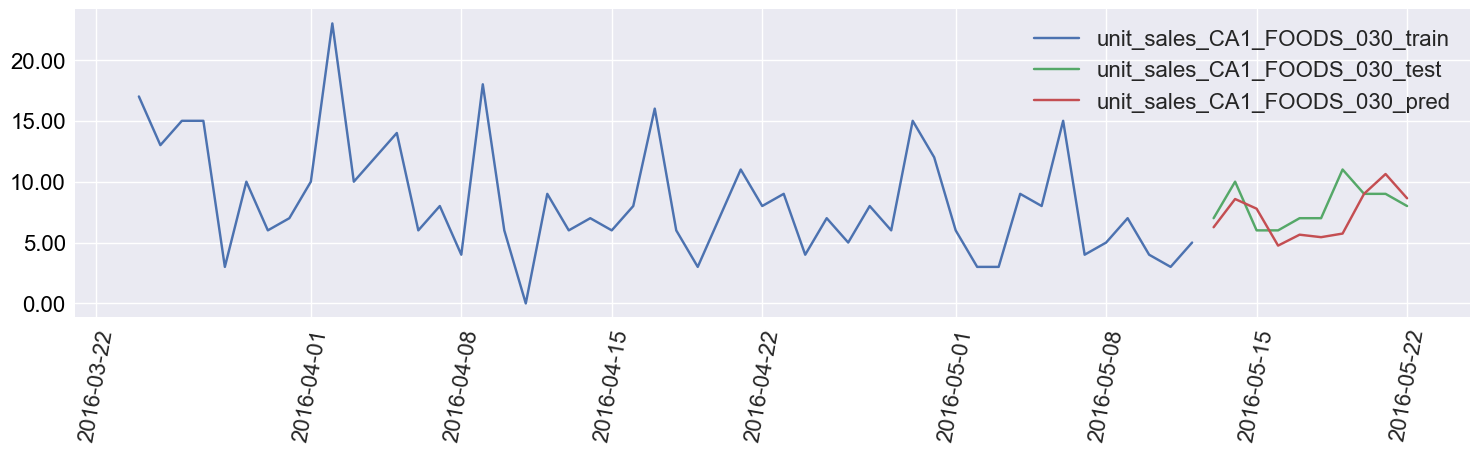

In [14]:
y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

df = dfXY_pred_ccm5.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

Predict

In [15]:
ts_period = pd.DateOffset(days=1)
dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sftfuvc.predict(Nperiods=5, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 27ms/step


,unit_sales_CA1_FOODS_030_pred
2016-05-23,5.757987
2016-05-24,6.000650
2016-05-25,5.388158
2016-05-26,5.556330
2016-05-27,6.719124


## Multivariate with Exogenous, and Categorical Variables

data

In [16]:
dfXYtf = dfXY[covars+exogvars+le_catvars].copy()
print(catvars)
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail(5))

['weekday', 'event_name_1', 'event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3


NN - Dense, Exog, categorical, Multivariate

In [23]:
Nlags = 5
tf_model_dense_exog_emb_mv = sf.get_dense_emb_nn(dfXYtf, Nlags, le_catvars, Ncovars= Ncovars, Nexogs = Nexogvars)

Ndense = 40
Nemb = 3
Nout = 7
cont_inputs = KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name='input_25'), name='input_25', description="created by layer 'input_25'")
cat_inputs_list = [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_26')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_27')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_28')>]
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 1)]          0           []                               
                                                  

Forecast Fit Multivariate with Exogenous and Catvars

In [24]:
# display data
# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA1_FOODS_030", "unit_sales_CA1_HOUSEHOLD_416" ,  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# forecast fit
Ntest = 10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_exog_emb_mv , tf_parameters=tf_params)

df_pred_mvcatmo = sfmvembmo.fit(dfXYtf)

print(f'\nmetrics = {sfmvembmo.metrics}')
dfXY_pred_mvcatmo = dfXYtf.join(df_pred_mvcatmo)
display(dfXY_pred_mvcatmo.tail())

dfXYtf


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 27ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 2.6411532547040353, 'MAE': 1.9330613613128662}, 'unit_sales_CA1_HOUSEHOLD_416_pred': {'RMSE': 1.3092300594856827, 'MAE': 1.1370441436767578}, 'unit_sales_CA1_FOODS_393_pred': {'RMSE': 4.449576223976272, 'MAE': 3.553562307357788}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,...,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_HOUSEHOLD_416_pred_error,unit_sales_CA1_HOUSEHOLD_416_pred_lower,unit_sales_CA1_HOUSEHOLD_416_pred_upper,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_393_test,unit_sales_CA1_FOODS_393_pred,unit_sales_CA1_FOODS_393_pred_error,unit_sales_CA1_FOODS_393_pred_lower,unit_sales_CA1_FOODS_393_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,...,1.390574,-0.609426,0.0,2.825781,NaN,5.0,3.950987,-1.049013,0.0,7.458479
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,...,1.373047,-0.626953,0.0,2.808254,NaN,8.0,4.258699,-3.741301,0.0,7.766191
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,...,1.423238,0.423238,0.0,2.858446,NaN,5.0,6.212538,1.212538,0.0,9.720030
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,...,1.462454,1.462454,0.0,2.897662,NaN,5.0,6.028448,1.028448,0.0,9.535940
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,...,1.411865,-1.588135,0.0,2.847073,NaN,15.0,5.640800,-9.359200,0.0,9.148292


Plot

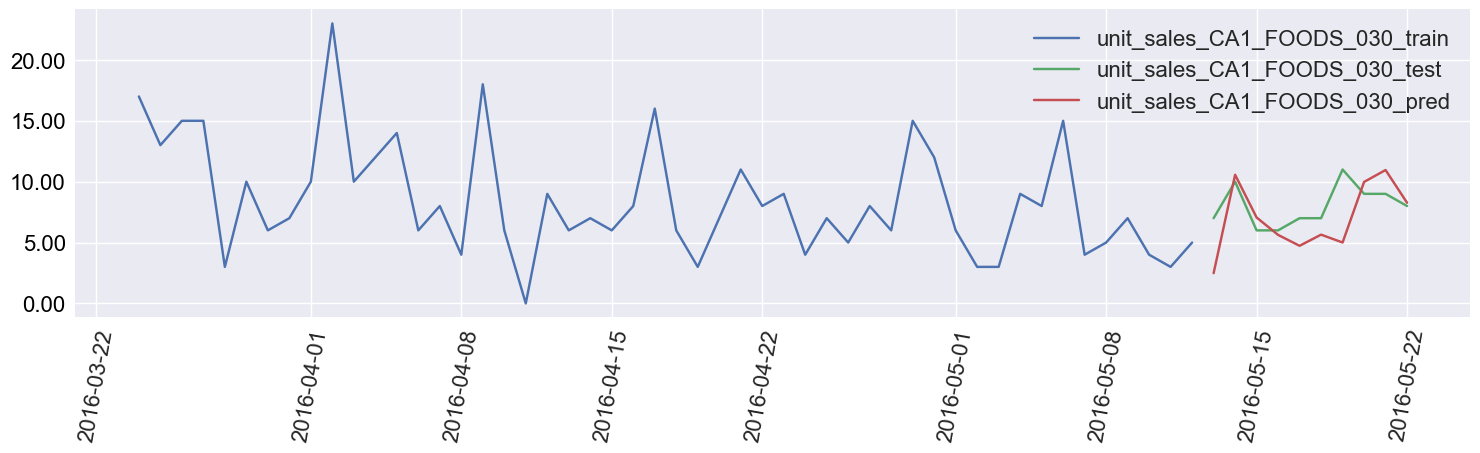

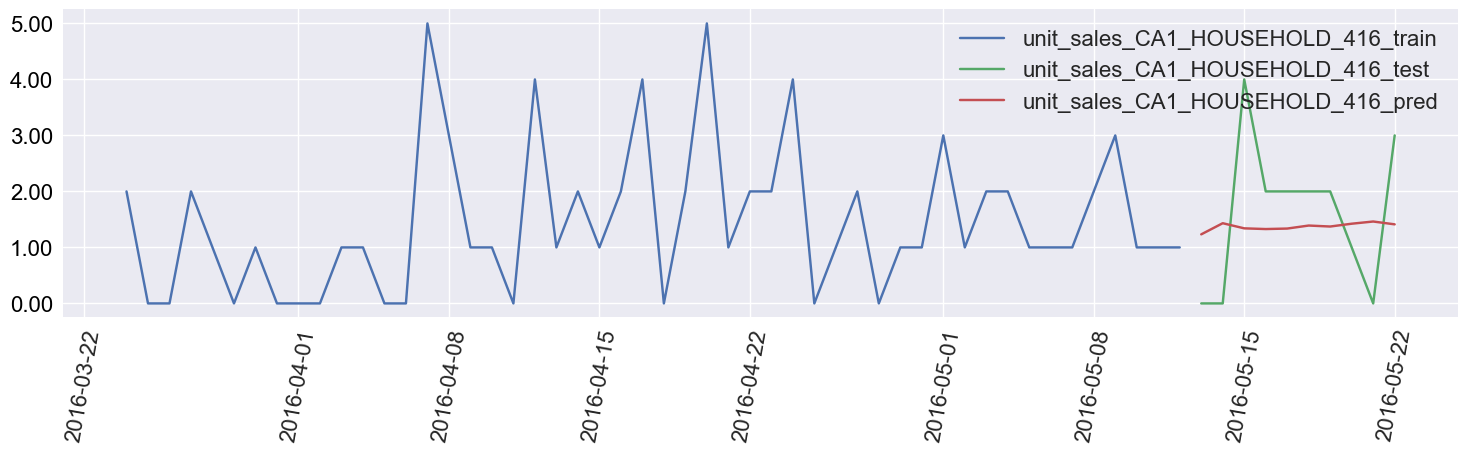

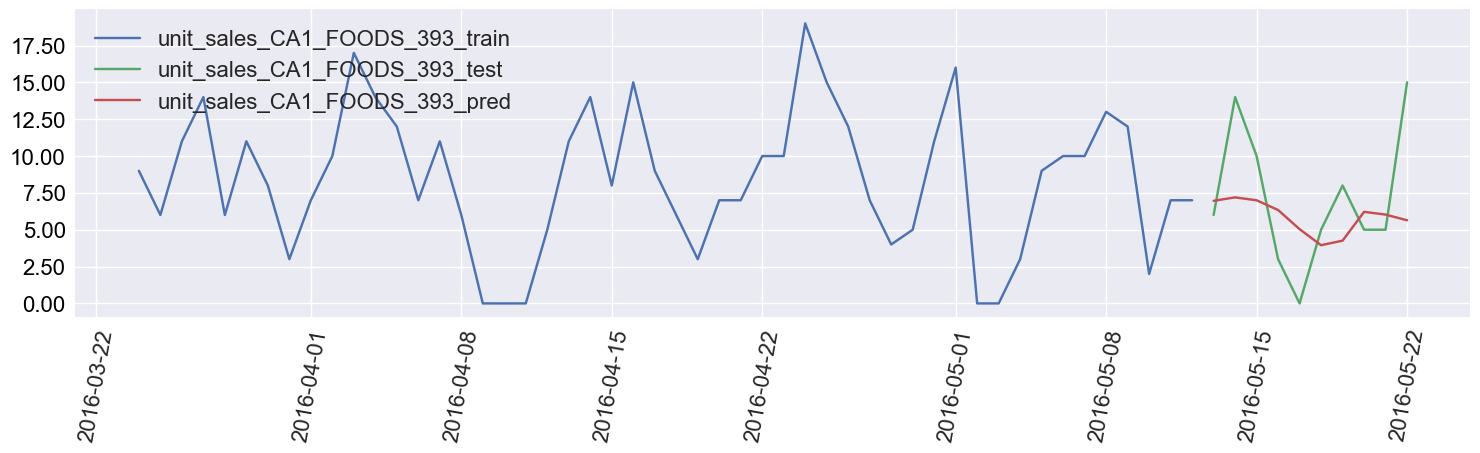

In [25]:


df = dfXY_pred_mvcatmo.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_HOUSEHOLD_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


y = "unit_sales_CA1_FOODS_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


Predict multivariate with exogenous and categorical

In [26]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 25ms/step


,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_FOODS_393_pred
2016-05-23,5.767777,1.293734,6.515613
2016-05-24,6.806952,1.361562,5.302248
2016-05-25,6.486378,1.360747,5.251453


## Multivariate - Exog, Exdog, Categorical, Multivariate

In [30]:
# same data as previous multivariate example

dfXYtf = dfXY[covars+exogvars+le_catvars].copy()
print(le_catvars)
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail())

['le_weekday', 'le_event_name_1', 'le_event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3


In [31]:
# transform dict
# -- transform can be one transform (str) or list
Nrw = 3 # rolling window widith
variable_transform_dict = {
    "unit_sales_CA1_FOODS_030" :["mean","std"],
    "unit_sales_CA1_HOUSEHOLD_416": ["mean","std"],
    "unit_sales_CA1_FOODS_393": ["mean","std"]
}

derived_variables_transformer = sf.rolling_transformer(variable_transform_dict, Nrw=Nrw)

derived_attributes = derived_variables_transformer.get_derived_attribute_names()

Nendogs = len(derived_attributes)

print(f'Nendogs = {Nendogs}')
print()
print(f'derived_attriburtes = {derived_attributes}')

Nendogs = 6

derived_attriburtes = ['unit_sales_CA1_FOODS_030_m1_mean3', 'unit_sales_CA1_FOODS_030_m1_std3', 'unit_sales_CA1_HOUSEHOLD_416_m1_mean3', 'unit_sales_CA1_HOUSEHOLD_416_m1_std3', 'unit_sales_CA1_FOODS_393_m1_mean3', 'unit_sales_CA1_FOODS_393_m1_std3']


In [32]:
Nlags = 5
tf_model_dense_endog_exog_emb_mv = sf.get_dense_emb_nn(dfXYtf, Nlags, le_catvars, Ncovars= Ncovars, Nendogs = Nendogs, Nexogs = Nexogvars)

Ndense = 46
Nemb = 3
Nout = 7
cont_inputs = KerasTensor(type_spec=TensorSpec(shape=(None, 46), dtype=tf.float32, name='input_24'), name='input_24', description="created by layer 'input_24'")
cat_inputs_list = [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_25')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_26')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_27')>]
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 1)]          0           []                               
                                                  

In [33]:

# display data
y = ["unit_sales_CA1_FOODS_030", "unit_sales_CA1_HOUSEHOLD_416" ,  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# forecast fit
Ntest = 10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags": Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_variables_transformer 

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvexen = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_endog_exog_emb_mv , tf_parameters=tf_params)

df_pred_mvexen = sfmvexen.fit(dfXYtf)

print(f'\nmetrics = {sfmvexen.metrics}')
dfXY_pred_mvexen = dfXY.join(df_pred_mvexen)
display(dfXY_pred_mvexen.tail())


y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 31ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 3.2132182200998085, 'MAE': 2.653296971321106}, 'unit_sales_CA1_HOUSEHOLD_416_pred': {'RMSE': 1.3298885039882538, 'MAE': 1.1505031824111938}, 'unit_sales_CA1_FOODS_393_pred': {'RMSE': 4.252336629917224, 'MAE': 3.3854929924011232}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,weekday,event_name_1,event_name_2,...,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_HOUSEHOLD_416_pred_error,unit_sales_CA1_HOUSEHOLD_416_pred_lower,unit_sales_CA1_HOUSEHOLD_416_pred_upper,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_393_test,unit_sales_CA1_FOODS_393_pred,unit_sales_CA1_FOODS_393_pred_error,unit_sales_CA1_FOODS_393_pred_lower,unit_sales_CA1_FOODS_393_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,Wednesday,NaN,NaN,...,1.332337,-0.667663,0.0,2.709535,NaN,5.0,3.936916,-1.063084,0.0,7.290266
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,Thursday,NaN,NaN,...,1.340091,-0.659909,0.0,2.717290,NaN,8.0,4.616940,-3.383060,0.0,7.970290
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,Friday,NaN,NaN,...,1.381936,0.381936,0.0,2.759134,NaN,5.0,6.424284,1.424284,0.0,9.777634
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,Saturday,NaN,NaN,...,1.399274,1.399274,0.0,2.776473,NaN,5.0,5.696042,0.696042,0.0,9.049392
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,Sunday,NaN,NaN,...,1.292918,-1.707082,0.0,2.670116,NaN,15.0,6.094972,-8.905028,0.0,9.448322


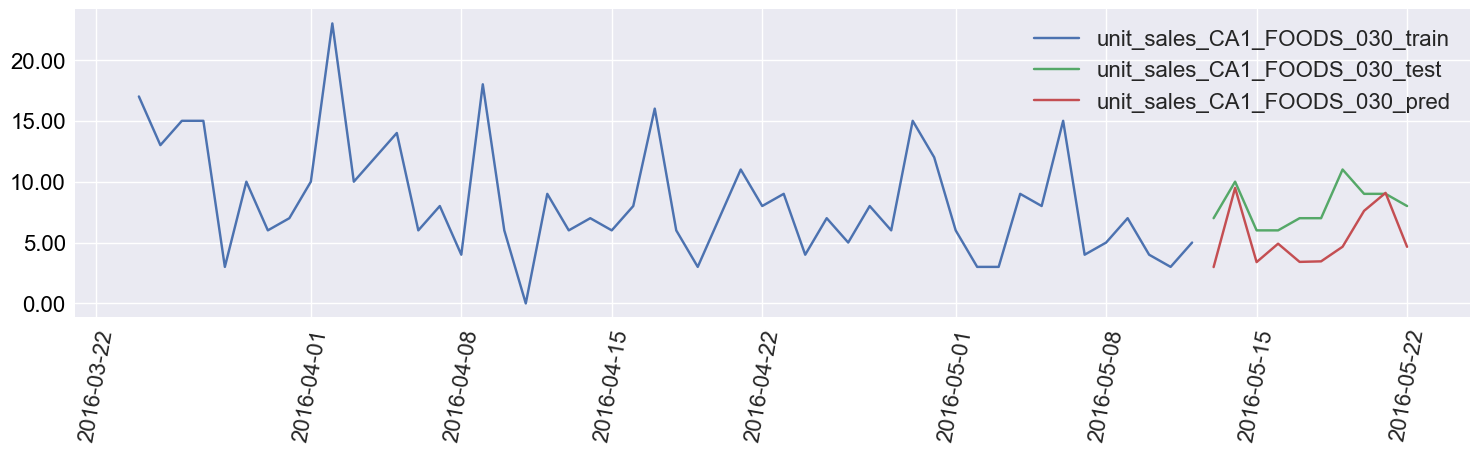

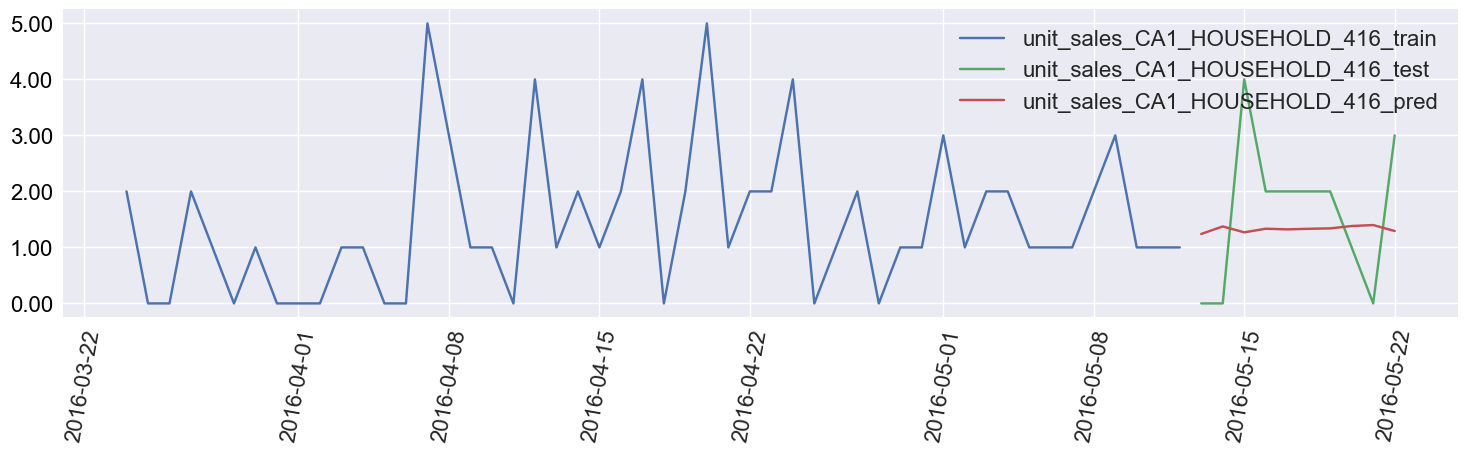

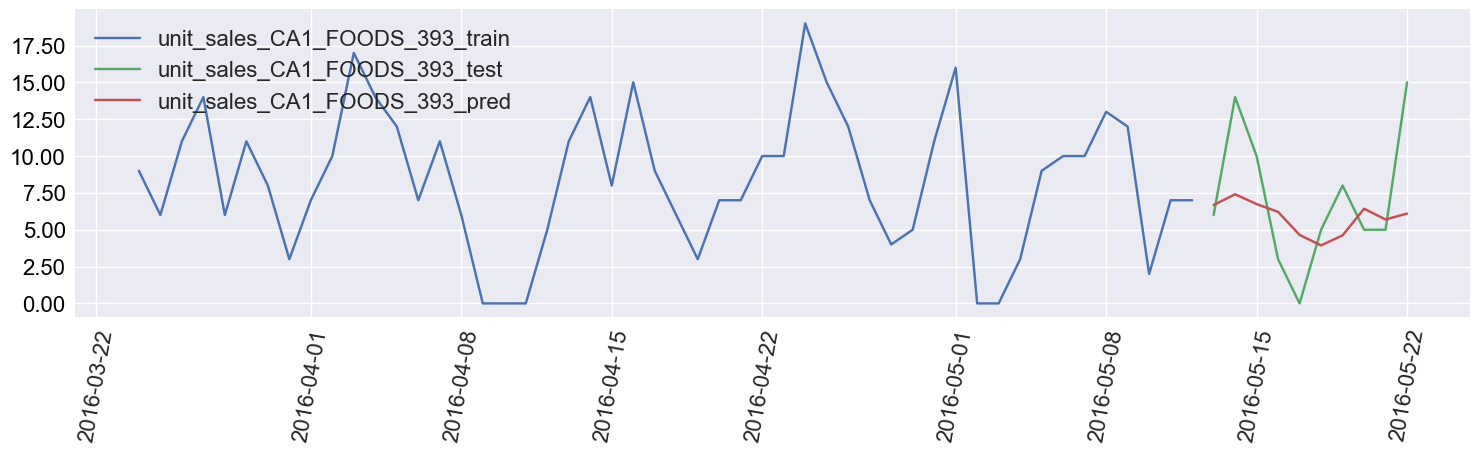

In [34]:
df = dfXY_pred_mvexen.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_HOUSEHOLD_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


y = "unit_sales_CA1_FOODS_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


In [35]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvexen.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 26ms/step


,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_FOODS_393_pred
2016-05-23,4.949048,1.330637,6.231155
2016-05-24,4.503481,1.353436,4.941900
2016-05-25,4.582548,1.338979,5.047238


## Train, Test and Validation

The purpose of this next exericise is for validation of our predictions against unseen data. The key goal is to validate that the sliding forecast (sforecast) 
out-of-sample predictions are the same as for predictions on unseen data. Below is the process for validating the out-of-sample predictions are correct.

We will use the multivariate, exogenous, endogenous, categorical case. 

Step 1. Create training/Test and validation (holdout set) data sets.   

Step 2.  Train Test with sforecast -  slidng forecast out of sample training and test, N-step recursive forecast methodFit the forecast model using the train/test data set

Step 3: Train (fit) using train set (separate from the validation set) ... 5 x 1-step recursive forward forecasts (should be identical to the above results)

Step 4. Compare the results of the two methods and ensure they produce equivalent results. Note, that thee will be some randomness in the predictions.


Before these steps - similar to all previous cases
* Setup dfXYtf data
* Derived variables Transform
* Exogenous variables ... previously setup with data import
* Define tensorflow model

In [30]:
# same data as previous multivariate example
dfXYtf = dfXY[covars+exogvars+le_catvars].copy()
all_columns = dfXYtf.columns
print("covars =",covars)
print("catvars =",catvars)
print("exogvars =",exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail(10))

covars = ['unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_044', 'unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOBBIES_418', 'unit_sales_CA1_FOODS_185', 'unit_sales_CA1_HOUSEHOLD_219', 'unit_sales_CA1_FOODS_393']
catvars = ['weekday', 'event_name_1', 'event_name_2']
exogvars = ['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-13,0.0,2.0,7.0,2.0,1.0,0.0,6.0,2016,5,19,0,100.7612,5,30,3
2016-05-14,0.0,1.0,10.0,0.0,6.0,1.0,14.0,2016,5,19,0,100.7612,6,30,3
2016-05-15,4.0,1.0,6.0,0.0,3.0,1.0,10.0,2016,5,19,0,100.7612,0,30,3
2016-05-16,2.0,2.0,6.0,1.0,0.0,1.0,3.0,2016,5,20,0,100.7612,1,30,3
2016-05-17,2.0,4.0,7.0,1.0,1.0,0.0,0.0,2016,5,20,0,100.7612,2,30,3
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3


Edogenous (derived) variables, same as before

In [29]:
# transform dict
# -- transform can be one transform (str) or list
Nrw = 3 # rolling window widith
variable_transform_dict = {
    "unit_sales_CA1_FOODS_030" :["mean","std"],
    "unit_sales_CA1_FOODS_393": ["mean","std"]
}

derived_variables_transformer = sf.rolling_transformer(variable_transform_dict, Nrw=Nrw)

derived_attributes = derived_variables_transformer.get_derived_attribute_names()

Nendogs = len(derived_attributes)

print(f'Nendogs = {Nendogs}')
print()
print(f'derived_attriburtes = {derived_attributes}')

Nendogs = 4

derived_attriburtes = ['unit_sales_CA1_FOODS_030_m1_mean3', 'unit_sales_CA1_FOODS_030_m1_std3', 'unit_sales_CA1_FOODS_393_m1_mean3', 'unit_sales_CA1_FOODS_393_m1_std3']


Step 1. Create training/Test and validation (holdout set) data sets.  

In [31]:
dfXY_traintest = dfXYtf
dfXY_train = dfXYtf[:1199] # training set ... all but the last 7 rows
dfXY_valid = dfXYtf[1199:] # validation last 7 rows
dfXY_valid.columns = [c+"_valid" if "unit_sales_" in c else c for c in dfXY_valid.columns]
print("dfXY_train")
display(dfXY_train.tail())

print("dfXY_valid")
display(dfXY_valid)

dfXY_train


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-11,1.0,1.0,3.0,4.0,3.0,0.0,7.0,2016,5,19,0,100.7612,3,30,3
2016-05-12,1.0,0.0,5.0,1.0,0.0,0.0,7.0,2016,5,19,0,100.7612,4,30,3
2016-05-13,0.0,2.0,7.0,2.0,1.0,0.0,6.0,2016,5,19,0,100.7612,5,30,3
2016-05-14,0.0,1.0,10.0,0.0,6.0,1.0,14.0,2016,5,19,0,100.7612,6,30,3
2016-05-15,4.0,1.0,6.0,0.0,3.0,1.0,10.0,2016,5,19,0,100.7612,0,30,3


dfXY_valid


,unit_sales_CA1_HOUSEHOLD_416_valid,unit_sales_CA1_FOODS_044_valid,unit_sales_CA1_FOODS_030_valid,unit_sales_CA1_HOBBIES_418_valid,unit_sales_CA1_FOODS_185_valid,unit_sales_CA1_HOUSEHOLD_219_valid,unit_sales_CA1_FOODS_393_valid,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-16,2.0,2.0,6.0,1.0,0.0,1.0,3.0,2016,5,20,0,100.7612,1,30,3
2016-05-17,2.0,4.0,7.0,1.0,1.0,0.0,0.0,2016,5,20,0,100.7612,2,30,3
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3


**Step 2**

Train Test out-of-sample forecast over the the entire dataset with sforecast: N-step recursive forecast, 7 x 1-step recursive predictions


TF Model for Step 2 - multivariate, dense, Categorical Embeddings + multiple output

In [40]:
Nlags = 5
tf_model_dense_endog_exog_emb_mv = sf.get_dense_emb_nn(dfXYtf, Nlags, le_catvars, Ncovars= Ncovars, Nendogs = Nendogs, Nexogs = Nexogvars)

Ndense = 44
Nemb = 3
Nout = 7
cont_inputs = KerasTensor(type_spec=TensorSpec(shape=(None, 44), dtype=tf.float32, name='input_41'), name='input_41', description="created by layer 'input_41'")
cat_inputs_list = [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_42')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_43')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_44')>]
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 1)]          0           []                               
                                                 

Step 2 fit predict

In [39]:
# sliding out of sample forecast
# display data
print("dfXY_traintest")
display(dfXY_traintest.tail(8))

y = ["unit_sales_CA1_FOODS_030",  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# forecast fit
Ntest = 7
Nhorizon = 7
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_variables_transformer
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_endog_exog_emb_mv, tf_parameters=tf_params)

df_pred = sfmvembmo.fit(dfXY_traintest)

df_pred_s2=df_pred[1199:][["unit_sales_CA1_FOODS_030_pred", "unit_sales_CA1_FOODS_393_pred"] ] # keep last 7 rows (i.e., 7 x 1-step recursive out-of-samppe)

df_pred_s2.columns = ["unit_sales_CA1_FOODS_030_pred_s2", "unit_sales_CA1_FOODS_393_pred_s2"] # change column names

df_pred_s2


dfXY_traintest


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-15,4.0,1.0,6.0,0.0,3.0,1.0,10.0,2016,5,19,0,100.7612,0,30,3
2016-05-16,2.0,2.0,6.0,1.0,0.0,1.0,3.0,2016,5,20,0,100.7612,1,30,3
2016-05-17,2.0,4.0,7.0,1.0,1.0,0.0,0.0,2016,5,20,0,100.7612,2,30,3
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 32ms/step


,unit_sales_CA1_FOODS_030_pred_s2,unit_sales_CA1_FOODS_393_pred_s2
date,,
2016-05-16,4.035011,5.471991
2016-05-17,3.751529,5.829780
2016-05-18,3.613147,5.476796
2016-05-19,4.242580,5.483692
2016-05-20,6.208941,5.927863
2016-05-21,7.644501,6.632951
2016-05-22,7.370591,6.229435


**Step 3** 

Train (fit) using train set (separate from the validation set) ... 7 x 1-step recursive forward forecasts (should be identical to the above results)


In [48]:
# transform dict
# -- transform can be one transform (str) or list
Nrw = 3 # rolling window widith
variable_transform_dict = {
    "unit_sales_CA1_FOODS_030" :["mean","std"],
    "unit_sales_CA1_FOODS_393": ["mean","std"]
}

derived_variables_transformer = sf.rolling_transformer(variable_transform_dict, Nrw=Nrw)

derived_attributes = derived_variables_transformer.get_derived_attribute_names()

Nendogs = len(derived_attributes)

print(f'Nendogs = {Nendogs}')
print()
print(f'derived_attriburtes = {derived_attributes}')

Nendogs = 4

derived_attriburtes = ['unit_sales_CA1_FOODS_030_m1_mean3', 'unit_sales_CA1_FOODS_030_m1_std3', 'unit_sales_CA1_FOODS_393_m1_mean3', 'unit_sales_CA1_FOODS_393_m1_std3']


TF Model for Step 3 - multivariate, dense, Categorical Embeddings + multiple output

In [45]:
Nlags = 5
tf_model_dense_endog_exog_emb_mv_2 = sf.get_dense_emb_nn(dfXYtf, Nlags, le_catvars, Ncovars= Ncovars, Nendogs = Nendogs, Nexogs = Nexogvars)

Ndense = 44
Nemb = 3
Nout = 7
cont_inputs = KerasTensor(type_spec=TensorSpec(shape=(None, 44), dtype=tf.float32, name='input_57'), name='input_57', description="created by layer 'input_57'")
cat_inputs_list = [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_58')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_59')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_60')>]
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 1)]          0           []                               
                                                 

In [41]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Nendogvars = 4
Ndense = Nlags * Ncovars + Nexogvars + Nendogvars #lagged covars (does not include unlagged covars) + exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_dense_emb2 = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb2.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense_emb2.summary())

Ndense = 44
Nemb = 3
Nout = 7
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_47 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 44)]         0           []                               
                                                             

fit and predict

In [49]:
# display data
print("dfXY_train")
display(dfXY_train.tail(5))

y = ["unit_sales_CA1_FOODS_030",  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will retrain/tune the existing model

# forecast fit
Ntest = 0
Nhorizon = 7
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_variables_transformer
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_endog_exog_emb_mv_2, tf_parameters=tf_params)

sfmvembmo.fit(dfXY_train)

# Forecast Nperiods forward 7 x 1-step recursive predictions
dfexogs=dfXY_traintest[1199:][exogvars]
dfcats=dfXY_traintest[1199:][le_catvars]
ts_period = pd.DateOffset(days=1)
df_pred_s3=sfmvembmo.predict(Nperiods=7,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred_s3.columns = ["unit_sales_CA1_FOODS_030_pred_s3",	"unit_sales_CA1_FOODS_393_pred_s3"]
df_pred_s3


dfXY_train


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-11,1.0,1.0,3.0,4.0,3.0,0.0,7.0,2016,5,19,0,100.7612,3,30,3
2016-05-12,1.0,0.0,5.0,1.0,0.0,0.0,7.0,2016,5,19,0,100.7612,4,30,3
2016-05-13,0.0,2.0,7.0,2.0,1.0,0.0,6.0,2016,5,19,0,100.7612,5,30,3
2016-05-14,0.0,1.0,10.0,0.0,6.0,1.0,14.0,2016,5,19,0,100.7612,6,30,3
2016-05-15,4.0,1.0,6.0,0.0,3.0,1.0,10.0,2016,5,19,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 23ms/step


,unit_sales_CA1_FOODS_030_pred_s3,unit_sales_CA1_FOODS_393_pred_s3
2016-05-16,5.833215,5.705356
2016-05-17,5.054470,5.192304
2016-05-18,2.317657,5.350032
2016-05-19,2.189001,5.801437
2016-05-20,4.860849,7.110623
2016-05-21,3.236298,7.831218
2016-05-22,2.161239,7.246848


Step 4. Compare the results of the two methods

ensure they are stistically equivalent and that the test 2 sliding forecast method is not exhibiting leakage

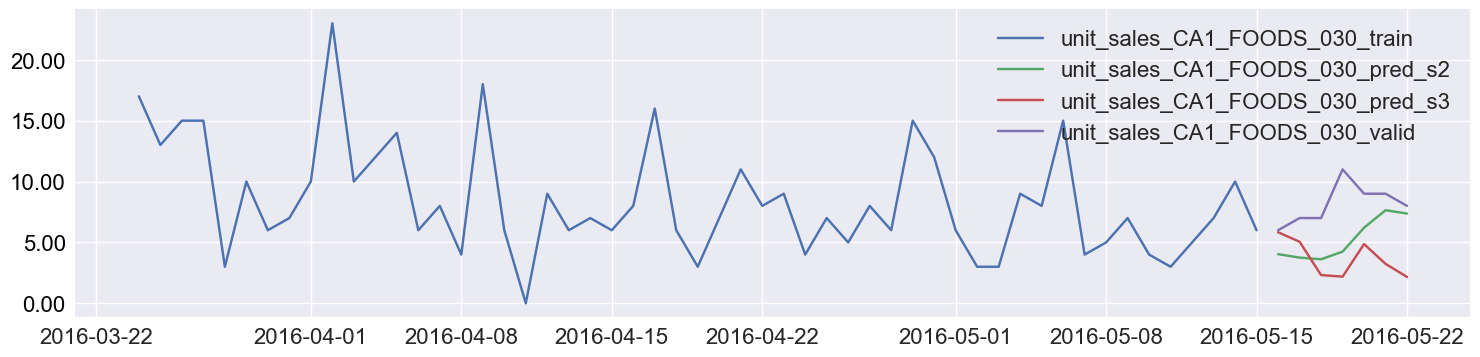

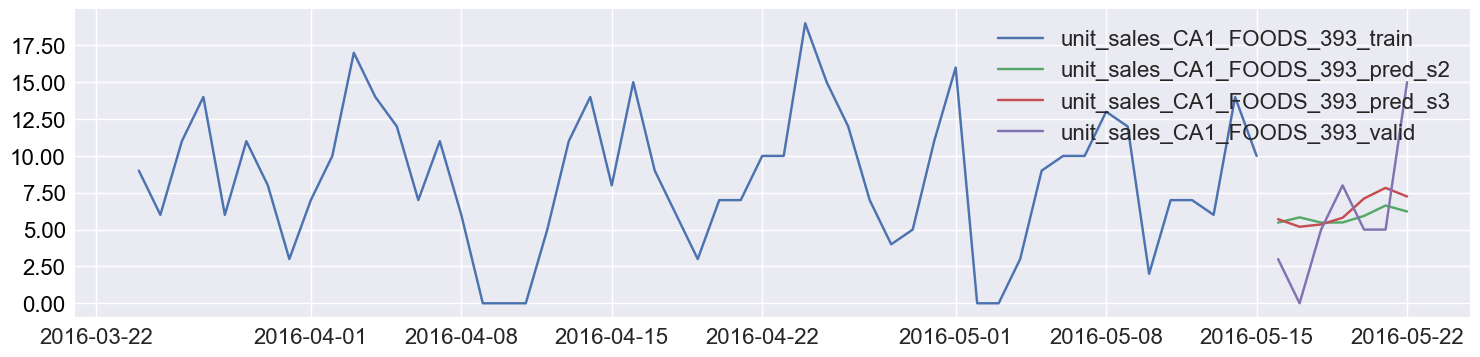

,unit_sales_CA1_FOODS_030_train,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_030_pred_s2,unit_sales_CA1_FOODS_393_pred_s2,unit_sales_CA1_FOODS_030_pred_s3,unit_sales_CA1_FOODS_393_pred_s3,unit_sales_CA1_FOODS_030_valid,unit_sales_CA1_FOODS_393_valid
date,,,,,,,,
2016-05-13,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-14,10.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-15,6.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-16,NaN,NaN,4.035011,5.471991,5.833215,5.705356,6.0,3.0
2016-05-17,NaN,NaN,3.751529,5.829780,5.054470,5.192304,7.0,0.0
2016-05-18,NaN,NaN,3.613147,5.476796,2.317657,5.350032,7.0,5.0
2016-05-19,NaN,NaN,4.242580,5.483692,2.189001,5.801437,11.0,8.0
2016-05-20,NaN,NaN,6.208941,5.927863,4.860849,7.110623,9.0,5.0
2016-05-21,NaN,NaN,7.644501,6.632951,3.236298,7.831218,9.0,5.0


In [50]:

# Join the training, predictions and validations for easy comparison 
dfXY_testtrainpred = pd.concat([dfXY_train[y], df_pred_s2])
dfXY_testtrainpred=dfXY_testtrainpred.rename({"unit_sales_CA1_FOODS_030":"unit_sales_CA1_FOODS_030_train","unit_sales_CA1_FOODS_393":"unit_sales_CA1_FOODS_393_train" }, axis=1)
dfXY_testtrainpred = dfXY_testtrainpred.join(df_pred_s3)
dfXY_testtrainpred = dfXY_testtrainpred.join(dfXY_valid[["unit_sales_CA1_FOODS_030_valid","unit_sales_CA1_FOODS_393_valid"]])


# plot
dfXY_plot = dfXY_testtrainpred.reset_index()

bp.lineplot(dfXY_plot.tail(60), x= "date", y=["unit_sales_CA1_FOODS_030_train", "unit_sales_CA1_FOODS_030_pred_s2", "unit_sales_CA1_FOODS_030_pred_s3","unit_sales_CA1_FOODS_030_valid"  ] , figsize=(18,4) , legend=True)

bp.lineplot(dfXY_plot.tail(60), x= "date", y=["unit_sales_CA1_FOODS_393_train", "unit_sales_CA1_FOODS_393_pred_s2", "unit_sales_CA1_FOODS_393_pred_s3","unit_sales_CA1_FOODS_393_valid"  ] , figsize=(18,4) , legend=True)


# display

display(dfXY_testtrainpred.tail(10))


## Multivarate - Exen Group to NN Output Linear Combining, Exogs, Covar MV

In [37]:
#### Data M5 7 items Week
file = "../data/M5_7items_week.csv"
sales_week_7_w = pd.read_csv(file, parse_dates = ["yearweek_dt"]).set_index("yearweek_dt")

### Prepare Data
y = ["unit_sales_FOODS_3_030"]
print(f'target variable = {y}')

# variable types
print("variable types ...")
covars = [c for c in sales_week_7_w.columns if "unit_sales_" in c]
catvars = [ "month", "event_name_1","event_name_2"]
exogvars = [ "yeariso" , "weekiso",  "snap_CA",  "CCI_USA", "sell_price_FOODS_3_030"]
exogs1 = [ "yeariso" , "weekiso",  "snap_CA",  "CCI_USA" ]
exogs2 = ["sell_price_FOODS_3_030"]
Ncatvars = len(catvars)
Ncovars = len(covars)
Nexogvars = len(exogvars)
exenvars = [exogs1, exogs2]

# dfXY ... covars + exogvars + catvars
cols = covars+catvars+exogvars
colsdp = cols  #+ ["yearweek_dt"]
dfXYdp = sales_week_7_w[colsdp].copy()
dfXY = sales_week_7_w[cols].copy()


# label Encoding
le_catvars = [ "le_"+ c for c in catvars ] # label encoded category columns
le = LabelEncoder()
dfXY[le_catvars] = dfXY[catvars].apply(le.fit_transform)

# embedding dimensions
eindim = [dfXY[le_catvars].groupby(c)[c].count().index.size + 1 for c in le_catvars] # add 1 to the dim or err in TF
eoutdim = [np.rint(np.log2(x)).astype(int) for x in eindim]

dfXY = dfXY[covars+exogvars+le_catvars]

target variable = ['unit_sales_FOODS_3_030']
variable types ...


In [39]:
### TensorFlow Model
Nlags = 5
Ndense1 = Nlags * Ncovars 
Ndense2 = len(exogs1)
Nlinear = len(exogs2) 
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = Ncovars

#Ndense = Nlags  # N continous/dense variables, in this case covars is 1 (univarate)

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
covarlags_in = Input((Ndense1,))
hcovarlags = Dense(Ndense1, activation='relu')(covarlags_in)

exogs1_in = Input((Ndense2,))
hexogs1 = Dense(Ndense2, activation='relu')(exogs1_in)

exogs2_in = Input((Nlinear,))
hexogs2 = Dense(Nlinear)(exogs2_in)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([hcovarlags]+emb_flat_list + [hexogs1] )
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense1 + Nembout + Ndense2 # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# combined to output ... combine the hidden reduced variables and the linear
combined_to_out = concatenate([h2c_d]+[hexogs2])

# output
output = Dense(Nout)(combined_to_out)  # linear activation ... linear combination 
model_tf_dense2_emb_so = Model(inputs=[covarlags_in, exogs1_in, exogs2_in, cat_inputs_list], outputs=output)

# define optimizer and compile
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_dense2_emb_so.compile(loss='mse', optimizer=optimizer)

In [40]:
    
# Fit
Ntest = 3
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "catvars":le_catvars,
    "exogvars":exogvars,
    "exenvars":exenvars
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sf_tf_dense_emb_so = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense2_emb_so, tf_parameters=tf_params)

df_pred = sf_tf_dense_emb_so.fit(dfXY)

pred_expected =  np.array([50.5, 46.3, 34.5 ])

y_pred = y[0]+"_pred"

pred_expected_p = pred_expected + 10
pred_expected_m = pred_expected - 10
pred_result = df_pred[y_pred].tail(Ntest).values

display(pred_result)

1/1 [==============================] - 0s 34ms/step


array([59.78197861, 43.6068573 , 36.73448944])

## Multivariate Exen Groups, Exogenous, Endogenous, Categorical, Multiple Output

Data

In [16]:

# unit_sales_CA_1_FOODS_2_FOODS_2_044
# unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416
# unit_sales_CA_1_FOODS_3_FOODS_3_393
# y forecast variable
#y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416" ]

# endogenous variables = new attribute names (i.e., derived attributes)
endogs =  ['unit_sales_CA1_FOODS_030_m1_mean3', 'unit_sales_CA1_HOUSEHOLD_416_m1_mean3', 
           'unit_sales_CA1_FOODS_393_m1_mean3', 'unit_sales_CA1_FOODS_030_m1_std3', 
           'unit_sales_CA1_HOUSEHOLD_416_m1_std3', 'unit_sales_CA1_FOODS_393_m1_std3']


exenvars = [ ['year', 'month', 'week', 'snap_CA'] + endogs, ['CCI_USA'] ] # envars list of lists. Each processed differently by the TF model
Nexenvars1 = len(exenvars[0])
Nexenvars2 = len(exenvars[1])
print(catvars)
print("exenvars =",exenvars)
print(f'Nexenvars1 = {Nexenvars1}')
print(f'Nexenvars2 = {Nexenvars2}')
dfXYtf= dfXY[covars+exogvars+le_catvars]
print("dfXYmvexcatso.shape =",dfXYtf.shape)
display(dfXYtf.head())

['weekday', 'event_name_1', 'event_name_2']
exenvars = [['year', 'month', 'week', 'snap_CA', 'unit_sales_CA1_FOODS_030_m1_mean3', 'unit_sales_CA1_HOUSEHOLD_416_m1_mean3', 'unit_sales_CA1_FOODS_393_m1_mean3', 'unit_sales_CA1_FOODS_030_m1_std3', 'unit_sales_CA1_HOUSEHOLD_416_m1_std3', 'unit_sales_CA1_FOODS_393_m1_std3'], ['CCI_USA']]
Nexenvars1 = 10
Nexenvars2 = 1
dfXYmvexcatso.shape = (1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,2013,2,5,1,98.72734,6,30,3
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,2013,2,5,1,98.72734,0,26,3
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,2013,2,6,1,98.72734,1,30,3
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,2,30,3
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,3,30,3


derived attributes ... for convenience, repeated from previous multivariate case 

In [17]:
# transform dict
# -- transform can be one transform (str) or list
Nrw = 3 # rolling window widith
variable_transform_dict = {
    "unit_sales_CA1_FOODS_030" :["mean","std"],
    "unit_sales_CA1_HOUSEHOLD_416": ["mean","std"],
    "unit_sales_CA1_FOODS_393": ["mean","std"]
}

derived_variables_transformer = sf.rolling_transformer(variable_transform_dict, Nrw=Nrw)

derived_attributes = derived_variables_transformer.get_derived_attribute_names()

Nendogs = len(derived_attributes)

print(f'Nendogs = {Nendogs}')
print()
print(f'derived_attriburtes = {derived_attributes}')

Nendogs = 6

derived_attriburtes = ['unit_sales_CA1_FOODS_030_m1_mean3', 'unit_sales_CA1_FOODS_030_m1_std3', 'unit_sales_CA1_HOUSEHOLD_416_m1_mean3', 'unit_sales_CA1_HOUSEHOLD_416_m1_std3', 'unit_sales_CA1_FOODS_393_m1_mean3', 'unit_sales_CA1_FOODS_393_m1_std3']


TF Model: exogenous, endogenous, catvars ... CCI_USA processed a little differently sent directly to the output layer

In [19]:
###### 4 sets of inputs ... dense1 (covar lags), dense2 (exogs1), linear (exogs2), and embeddings (categorical inputs)
# linear exog directly to output
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Ndense1 = Nlags * Ncovars #lagged covars (does not include unlagged covars) + exogvars
Ndense2 = Nexenvars1
Nlinear = Nexenvars2
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense1 = {Ndense1}')
print(f'Nemb = {Nemb}')
print(f'Ndense2 = {Ndense2}')
print(f'Nout = {Nout}')

# Dense input 1  ...  covar lags 
dense_inputs1 = Input((Ndense1,))
h1d = Dense(Ndense1, activation='relu')(dense_inputs1)

# Dense input 2 ...  exogs 1
dense_inputs2 = Input((Ndense2,))
h2d = Dense(Ndense2, activation='relu')(dense_inputs2)

# Input layer ... exogs2 linear input that will be passed directly to output
linear_inputs = Input((Nlinear))
hlinear = Dense(Nlinear, )(linear_inputs) # linear activation = None

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined  ... combine lagged covars, embeddings, exogs1
combined = concatenate([h1d]+ emb_flat_list + [h2d])
combined_d = Dropout(0.2)(combined)

# dense reduction layers... Ndense1 lag variables + Ndense2 exogs1
Nh1c = Ndense1 + Ndense2 + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# combined to output ... combine the hidden reduced variables and the linear
comb_to_out = concatenate([h2c_d]+[hlinear])

# output
output = Dense(Nout)(comb_to_out)  # linear activation ... linear combination, activation = None 
model_tf_dense2_emb = Model(inputs=[dense_inputs1, dense_inputs2, linear_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_dense2_emb.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense2_emb.summary())

Ndense1 = 35
Nemb = 3
Ndense2 = 10
Nout = 7
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 35)]         0           []                               
                                                

TF fit forecast - exogenous, endogenous, categorical, exen groups

In [21]:
exenvars

[['year',
  'month',
  'week',
  'snap_CA',
  'unit_sales_CA1_FOODS_030_m1_mean3',
  'unit_sales_CA1_HOUSEHOLD_416_m1_mean3',
  'unit_sales_CA1_FOODS_393_m1_mean3',
  'unit_sales_CA1_FOODS_030_m1_std3',
  'unit_sales_CA1_HOUSEHOLD_416_m1_std3',
  'unit_sales_CA1_FOODS_393_m1_std3'],
 ['CCI_USA']]

In [20]:

# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA1_FOODS_030", "unit_sales_CA1_HOUSEHOLD_416" ,  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# forecast fit
Ntest = 10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "exenvars":exenvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_variables_transformer

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense2_emb, tf_parameters=tf_params)

df_pred = sfmvembmo.fit(dfXYtf)

print(f'\nmetrics = {sfmvembmo.metrics}')

dfXYtf_pred = dfXYtf.join(df_pred)

dfXYtf_pred

dfXYtf


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 37ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 2.696517693969886, 'MAE': 2.0882076740264894}, 'unit_sales_CA1_HOUSEHOLD_416_pred': {'RMSE': 1.285153041250963, 'MAE': 1.0939462542533875}, 'unit_sales_CA1_FOODS_393_pred': {'RMSE': 4.3294962808158735, 'MAE': 3.3974020004272463}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,...,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_HOUSEHOLD_416_pred_error,unit_sales_CA1_HOUSEHOLD_416_pred_lower,unit_sales_CA1_HOUSEHOLD_416_pred_upper,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_393_test,unit_sales_CA1_FOODS_393_pred,unit_sales_CA1_FOODS_393_pred_error,unit_sales_CA1_FOODS_393_pred_lower,unit_sales_CA1_FOODS_393_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,2013,2,5,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,2013,2,5,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,2013,2,6,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,2013,2,6,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,2013,2,6,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,...,1.595170,-0.404830,0.019179,3.124860,NaN,5.0,3.895793,-1.104207,0.0,6.880786
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,...,1.557026,-0.442974,0.000000,3.086716,NaN,8.0,4.167212,-3.832788,0.0,7.152204
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,...,1.564823,0.564823,0.000000,3.094514,NaN,5.0,6.004841,1.004841,0.0,8.989834


Plot

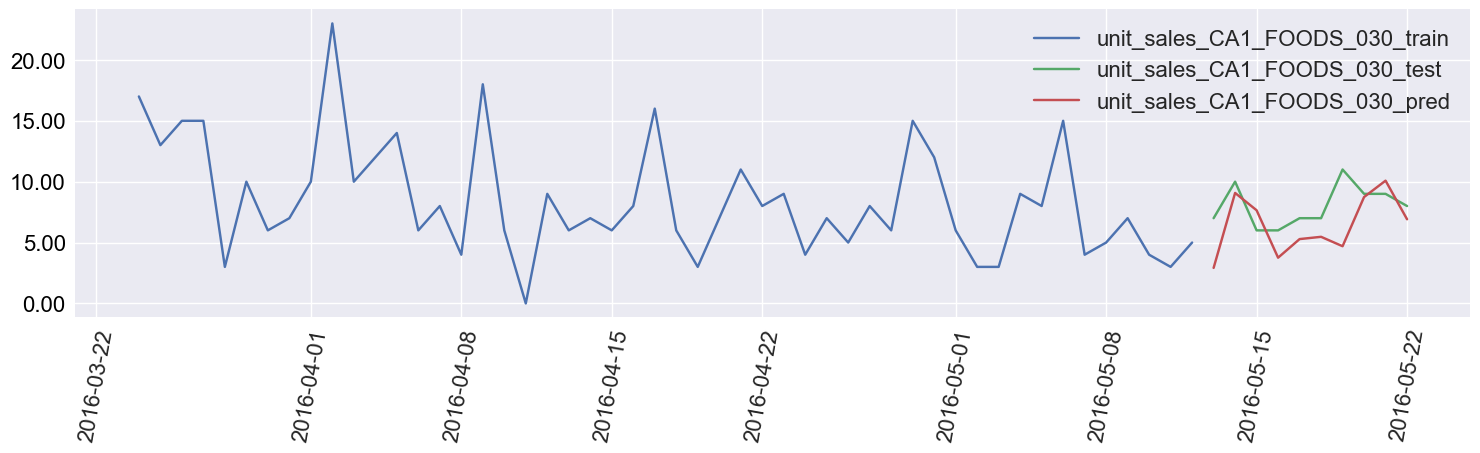

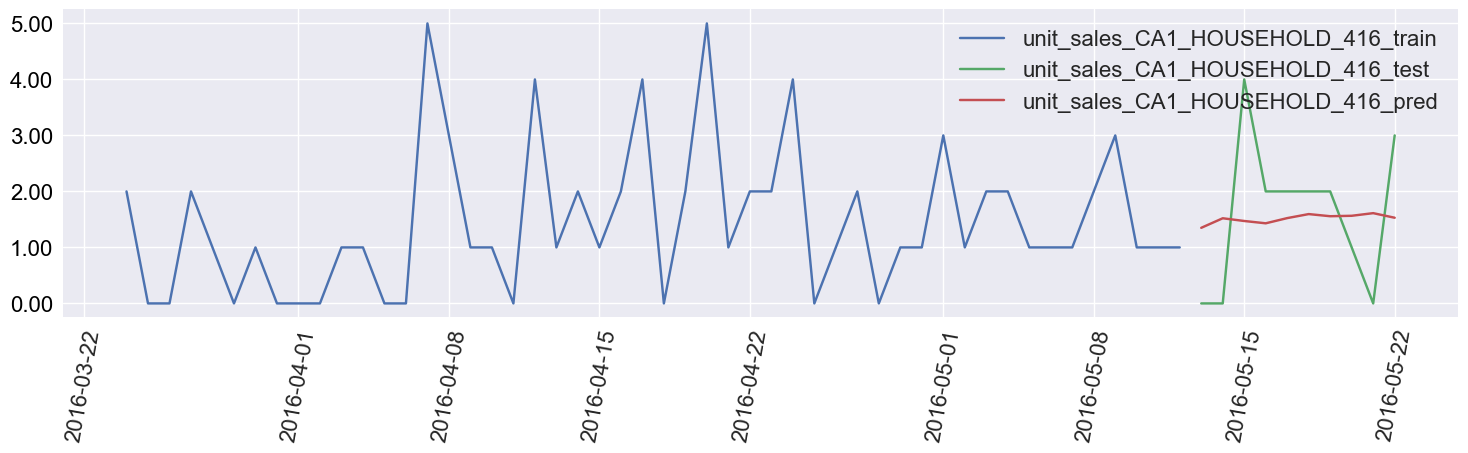

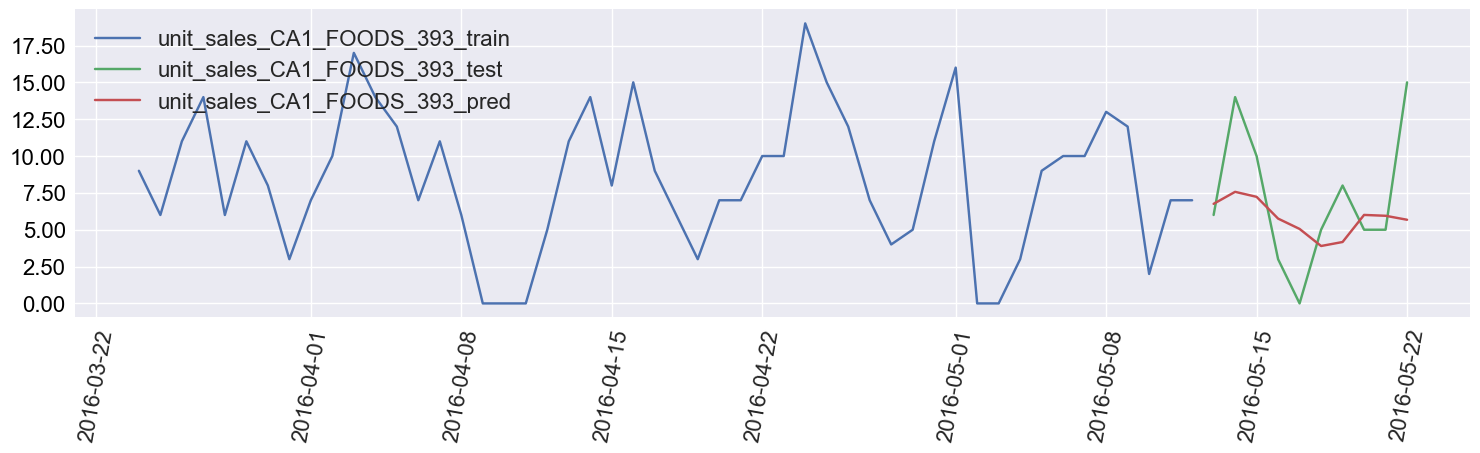

In [22]:
df = dfXYtf_pred.reset_index() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_HOUSEHOLD_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_FOODS_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

predict tf - multivariate, exogenous, endogenous, categorical, exen groups

In [23]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=5,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 26ms/step


,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_FOODS_393_pred
2016-05-23,4.310909,1.414922,6.250694
2016-05-24,5.778350,1.466352,5.987021
2016-05-25,4.161865,1.492625,4.875897
2016-05-26,2.238015,1.410581,5.209850
2016-05-27,2.888876,1.375323,6.090588


ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

## LSTM Multivariate

Data

In [24]:
y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_FOODS_2_FOODS_2_044" ]

endogs =  ['unit_sales_CA1_FOODS_030_m1_mean3', 'unit_sales_CA1_HOUSEHOLD_416_m1_mean3', 
           'unit_sales_CA1_FOODS_393_m1_mean3', 'unit_sales_CA1_FOODS_030_m1_std3', 
           'unit_sales_CA1_HOUSEHOLD_416_m1_std3', 'unit_sales_CA1_FOODS_393_m1_std3']

dfXYtf = dfXY[covars+exogvars+le_catvars]
print(catvars)
print(endogs)
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.head())

['weekday', 'event_name_1', 'event_name_2']
['unit_sales_CA1_FOODS_030_m1_mean3', 'unit_sales_CA1_HOUSEHOLD_416_m1_mean3', 'unit_sales_CA1_FOODS_393_m1_mean3', 'unit_sales_CA1_FOODS_030_m1_std3', 'unit_sales_CA1_HOUSEHOLD_416_m1_std3', 'unit_sales_CA1_FOODS_393_m1_std3']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,2013,2,5,1,98.72734,6,30,3
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,2013,2,5,1,98.72734,0,26,3
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,2013,2,6,1,98.72734,1,30,3
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,2,30,3
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,3,30,3


Endogenous derived variables, repeated here for convenience

In [25]:
# transform dict
# -- transform can be one transform (str) or list
Nrw = 3 # rolling window widith
variable_transform_dict = {
    "unit_sales_CA1_FOODS_030" :["mean","std"],
    "unit_sales_CA1_HOUSEHOLD_416": ["mean","std"],
    "unit_sales_CA1_FOODS_393": ["mean","std"]
}

derived_variables_transformer = sf.rolling_transformer(variable_transform_dict, Nrw=Nrw)

derived_attributes = derived_variables_transformer.get_derived_attribute_names()

Nendogs = len(derived_attributes)

print(f'Nendogs = {Nendogs}')
print()
print(f'derived_attriburtes = {derived_attributes}')

Nendogs = 6

derived_attriburtes = ['unit_sales_CA1_FOODS_030_m1_mean3', 'unit_sales_CA1_FOODS_030_m1_std3', 'unit_sales_CA1_HOUSEHOLD_416_m1_mean3', 'unit_sales_CA1_HOUSEHOLD_416_m1_std3', 'unit_sales_CA1_FOODS_393_m1_mean3', 'unit_sales_CA1_FOODS_393_m1_std3']


In [5]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_tf(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
        
        v1 = "unit_sales_CA1_FOODS_030"
        v2 = "unit_sales_CA1_HOUSEHOLD_416"
        v3 = "unit_sales_CA1_FOODS_393"
        self.vlist = [v1, v2, v3]
        f1 = lambda x:x+"_m1_ravg"+str(Nr)
        f2 = lambda x:x+"_m1_rstd"+str(Nr)
        self.new_attributes = [f(v) for f in (f1, f2 )for v in self.vlist]
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
                # variables
        
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        for v in self.vlist:
            v_ravg = v+"_m1_ravg"+str(Nr)
            v_rstd =  v+"_m1_rstd"+str(Nr)
            v_m1 = v+"_m1"
            dfnew[v_ravg] = dfnew[v_m1].rolling(window=Nr).mean()
            dfnew[v_rstd] = dfnew[v_m1].rolling(window=Nr).std()

        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows that should be desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return self.new_attributes
 
cols = ["unit_sales_CA1_FOODS_030" , "unit_sales_CA1_HOUSEHOLD_416" , "unit_sales_CA1_FOODS_393"]        
dfXY_m1 = dfXYtf[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_tf().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_tf()
dfXY_m1[["unit_sales_CA1_FOODS_030_m1" , "unit_sales_CA1_HOUSEHOLD_416_m1" , "unit_sales_CA1_FOODS_393_m1" ]] = dfXY_m1[["unit_sales_CA1_FOODS_030" , "unit_sales_CA1_HOUSEHOLD_416" , "unit_sales_CA1_FOODS_393"]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

new_attributes = drived_var_transform.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_393,unit_sales_CA1_FOODS_030_m1,unit_sales_CA1_HOUSEHOLD_416_m1,unit_sales_CA1_FOODS_393_m1,unit_sales_CA1_FOODS_030_m1_ravg3,unit_sales_CA1_FOODS_030_m1_rstd3,unit_sales_CA1_HOUSEHOLD_416_m1_ravg3,unit_sales_CA1_HOUSEHOLD_416_m1_rstd3,unit_sales_CA1_FOODS_393_m1_ravg3,unit_sales_CA1_FOODS_393_m1_rstd3
date,,,,,,,,,,,,
2016-05-18,7.0,2.0,5.0,7.0,2.0,0.0,6.333333,0.577350,2.666667,1.154701,4.333333,5.131601
2016-05-19,11.0,2.0,8.0,7.0,2.0,5.0,6.666667,0.577350,2.000000,0.000000,2.666667,2.516611
2016-05-20,9.0,1.0,5.0,11.0,2.0,8.0,8.333333,2.309401,2.000000,0.000000,4.333333,4.041452
2016-05-21,9.0,0.0,5.0,9.0,1.0,5.0,9.000000,2.000000,1.666667,0.577350,6.000000,1.732051
2016-05-22,8.0,3.0,15.0,9.0,0.0,5.0,9.666667,1.154701,1.000000,1.000000,6.000000,1.732051


Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_393,unit_sales_CA1_FOODS_030_m1,unit_sales_CA1_HOUSEHOLD_416_m1,unit_sales_CA1_FOODS_393_m1
date,,,,,,
2016-05-20,9.0,1.0,5.0,11.0,2.0,8.0
2016-05-21,9.0,0.0,5.0,9.0,1.0,5.0
2016-05-22,8.0,3.0,15.0,9.0,0.0,5.0



new_attribute_names = ['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']


LSTM (covariate lags) + Dense (exogenous vars) + Embeddings (categorical vars)

In [26]:
# TensorFlow model ... LSTM (covar lags) Embeddings (categorical) + Dense (exog vars), Multiple Ouput
Nlags = 5
Nlstmsteps = Nlags   #lagged covars (does not include unlagged covars)
Nlstmfeatures = Ncovars
Nexogs = len(exogvars)
Nendogs = len(endogs)
Ndense = Nexogs + Nendogs # exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print("Nlstmsteps =",Nlstmsteps)
print("Nlstmfeatures =",Ncovars)
print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

lstm_inputs = Input((Nlstmsteps,Nlstmfeatures))   # number of inputs = Nlags , number of features = Ncovars
h1lstm= LSTM(Nlstmsteps, activation='relu', input_shape = (Nlstmsteps, Nlstmfeatures))(lstm_inputs) # nsteps = Nlags

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
dense_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(dense_inputs)

# embeddings, cat vars
emb_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,emb_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1lstm] +[h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Nlstmsteps*Nlstmfeatures + Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_lstm = Model(inputs=[lstm_inputs, dense_inputs, emb_inputs_list], outputs=output)

# define optimizer and compile ..
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_lstm.compile(loss='mse', optimizer=optimizer)

print(model_tf_lstm.summary())

Nlstmsteps = 5
Nlstmfeatures = 7
Ndense = 11
Nemb = 3
Nout = 7
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 5, 7)]       0           []                               
                             

In [27]:

# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA1_FOODS_030", "unit_sales_CA1_HOUSEHOLD_416" ,  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

Ntest = 10
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "catvars":le_catvars,
    "exogvars":exogvars,
    "derived_attributes_transform":derived_variables_transformer
    }  

tf_params = {
    "Nepochs_i": 1000,
    "Nepochs_t": 400,
    "batch_size":100,
    "lstm": True
}

sflstm = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_lstm, tf_parameters=tf_params)

df_pred =sflstm.fit(dfXYtf)

print(f'\nmetrics = {sflstm.metrics}')
dfXYtf_pred = dfXYtf.join(df_pred)
display(dfXYtf_pred.tail())

dfXYtf


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 28ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 2.7670041502346168, 'MAE': 2.3478591442108154}, 'unit_sales_CA1_HOUSEHOLD_416_pred': {'RMSE': 1.3152357482920598, 'MAE': 1.1718379020690919}, 'unit_sales_CA1_FOODS_393_pred': {'RMSE': 4.393873715003114, 'MAE': 3.3968574523925783}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,...,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_HOUSEHOLD_416_pred_error,unit_sales_CA1_HOUSEHOLD_416_pred_lower,unit_sales_CA1_HOUSEHOLD_416_pred_upper,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_393_test,unit_sales_CA1_FOODS_393_pred,unit_sales_CA1_FOODS_393_pred_error,unit_sales_CA1_FOODS_393_pred_lower,unit_sales_CA1_FOODS_393_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,...,1.255321,-0.744679,0.0,2.726787,NaN,5.0,4.014662,-0.985338,0.0,7.319036
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,...,1.327405,-0.672595,0.0,2.798871,NaN,8.0,4.297774,-3.702226,0.0,7.602148
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,...,1.425761,0.425761,0.0,2.897227,NaN,5.0,5.323827,0.323827,0.0,8.628201
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,...,1.536321,1.536321,0.0,3.007787,NaN,5.0,6.701585,1.701585,0.0,10.005959
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,...,1.470436,-1.529564,0.0,2.941902,NaN,15.0,6.150726,-8.849274,0.0,9.455100


Plot

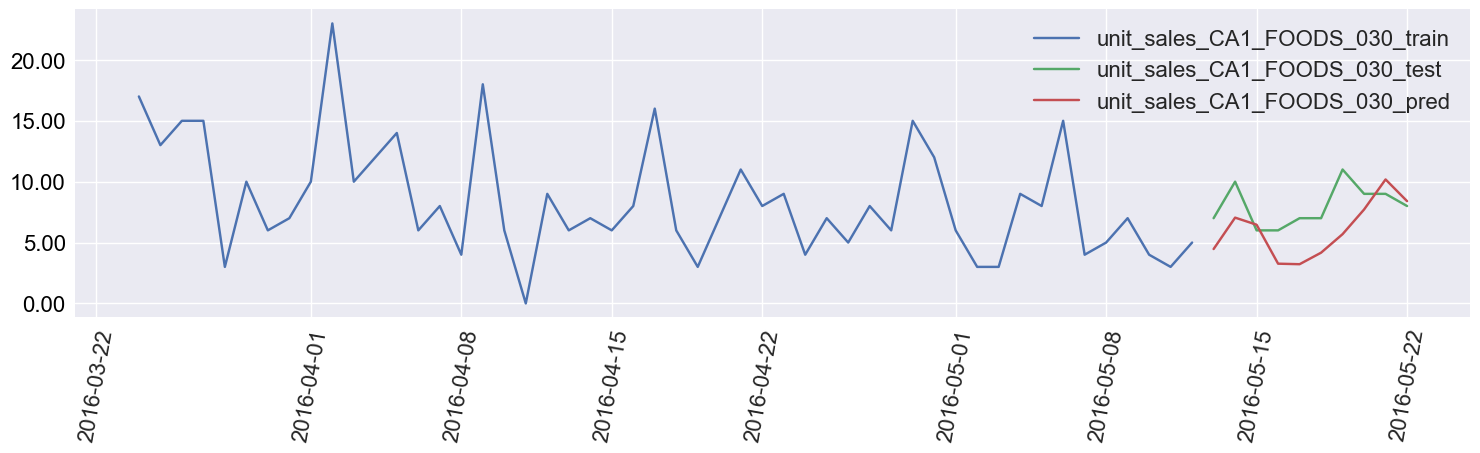

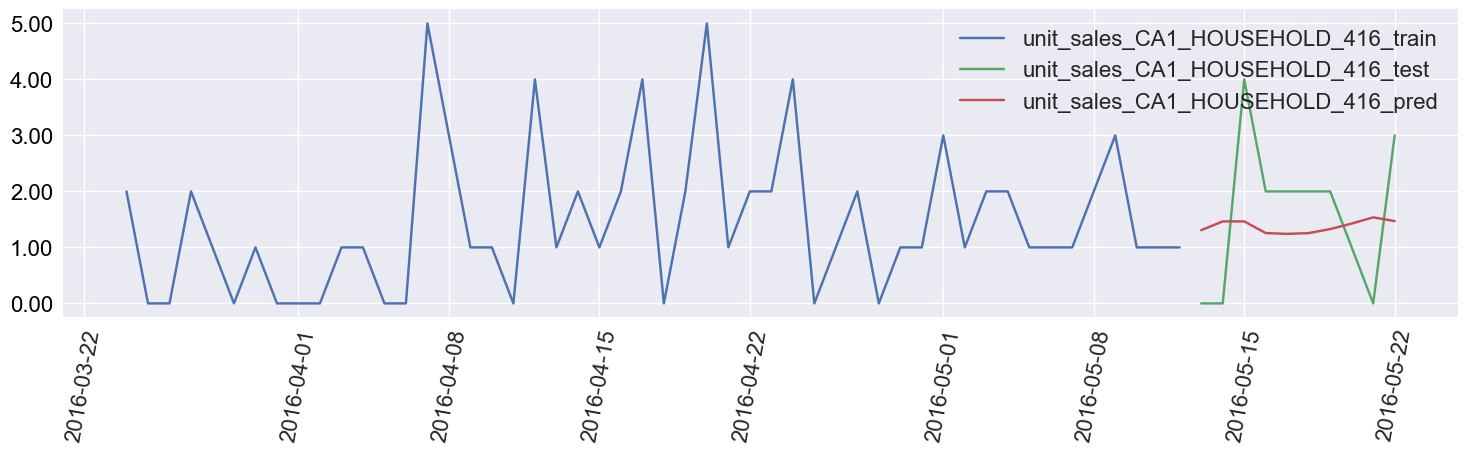

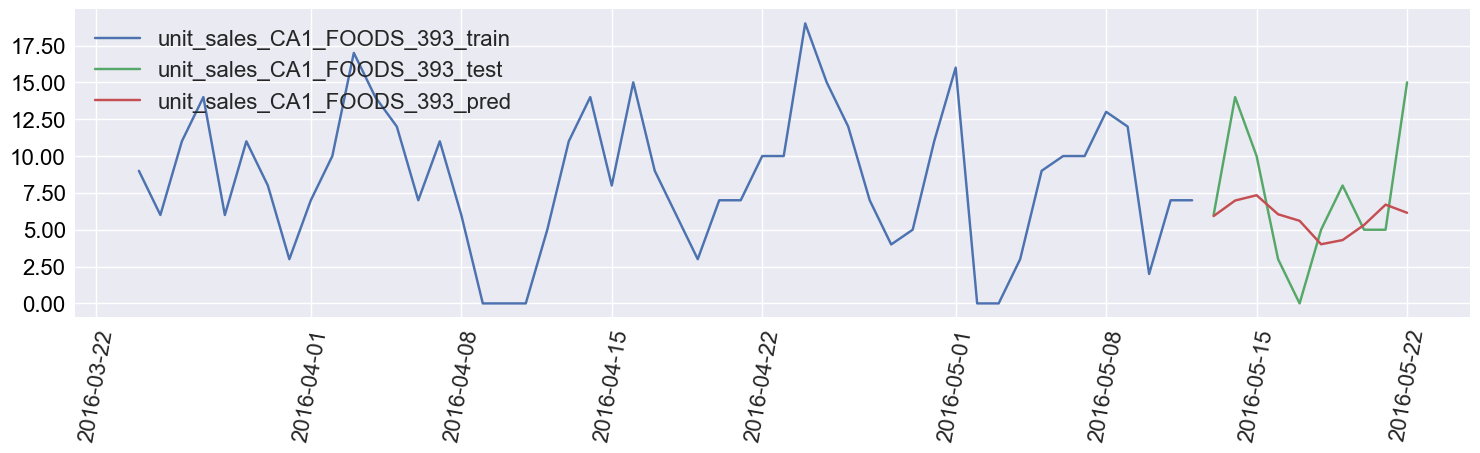

In [28]:
df = dfXYtf_pred.reset_index() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_HOUSEHOLD_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_FOODS_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

predict  lstm, multivariate, exogvars, endogvars, categorical 

In [29]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sflstm.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 27ms/step


,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_FOODS_393_pred
2016-05-23,3.526757,1.262799,5.449667
2016-05-24,3.496650,1.260301,5.332349
2016-05-25,2.847171,1.228279,5.379045
